In [1]:
#actualise automatiquement les modules importés
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch

from advi import ADVI
from ppca import PPCA_with_ARD_model
from sklearn.preprocessing import StandardScaler

# PPCA

[[ 1.]
 [-1.]]
True principal axes:
[[ 1.]
 [-1.]]
Shift:
[ 0. 10.]


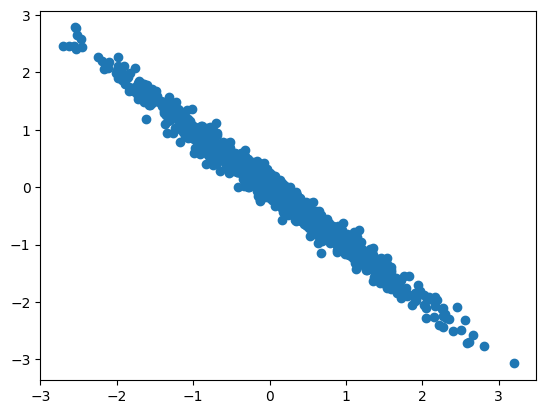

In [2]:

# note that in the function below D should be greater then K
def build_toy_dataset(N, D, K, sigma=1):
    x_train = np.zeros([D, N])
    w = np.zeros([D,K])
    for k in range(K):
        w[k,k]=1.0/(k+1)
        w[k+1,k]=-1.0/(k+1)
    print(w)
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    shift=np.zeros([D])
    shift[1]=10
    for d in range(D):
      for n in range(N):
        x_train[d, n] = np.random.normal(mean[d, n], sigma)+shift[d]
    print("True principal axes:")
    print(w)
    print("Shift:")
    print(shift)
    return x_train.astype(np.float32,copy=False).transpose(1, 0)


#ed.set_seed(142)

N = 1000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

# DATA

scaler = StandardScaler()
x_train = build_toy_dataset(N, D, K, sigma = 0.1)
x_train = scaler.fit_transform(x_train)
x_train = torch.tensor(x_train)
plt.plot(x_train[:,0],x_train[:, 1],'o')

**takes 5 minutes to run**

Fitting...: 100%|██████████| 100/100 [09:37<00:00,  5.77s/it]


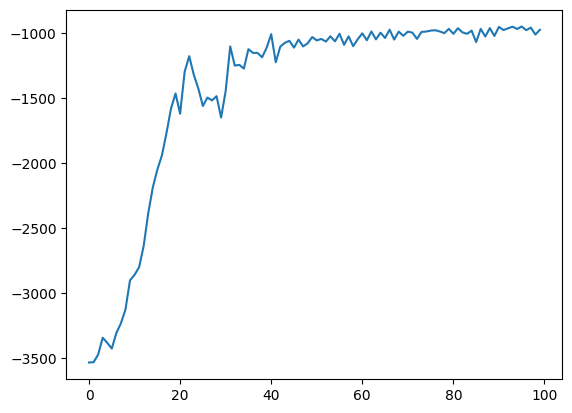

In [10]:
#actualise automatiquement les modules importés
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch

from advi import ADVI
from ppca import PPCA_model, PPCA_with_ARD_model, PPCA_ARD_True

ppca_K = 2

model = PPCA_with_ARD_model(D, ppca_K)

param_keys = model.named_params
param_dims = model.dim_parameters
key_pos = model.key_pos
advi = ADVI(model, num_samples = 5, batch_size=1000, lr=0.5, mode='meanfield', num_epochs=100)

%matplotlib inline
advi.fit(x_train, method="Adam", plotting=True, use_grad_clip=False)

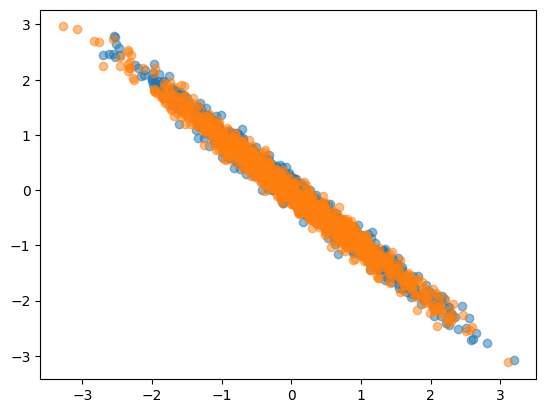

In [11]:
W = advi.model_params.vparams[0, :D*ppca_K].view(D, ppca_K)
mu = advi.model_params.vparams[0, D*ppca_K:D*ppca_K+D]
sigma = advi.model_params.vparams[0, D*ppca_K+D:D*ppca_K+2*D]
alpha = advi.model_params.vparams[0, D*ppca_K+2*D:]

samples = model.rsample(1000, W, mu, torch.exp(sigma), torch.exp(alpha)).detach().numpy()
plt.scatter(x_train[:, 0], x_train[:, 1], alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.show()

# GMM

[0.41765807 0.58234193]
[[-3  5]
 [-1  3]]
[[2.75476221 0.48506325]
 [0.12581833 2.36920163]]


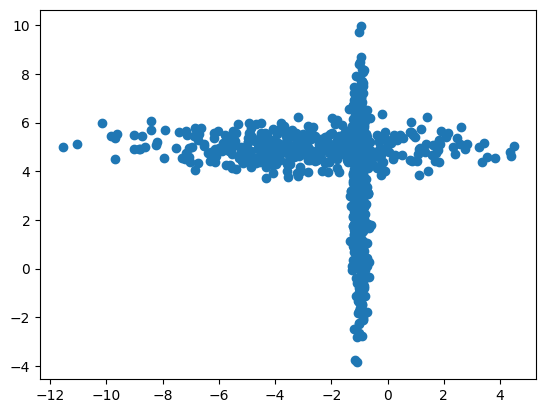

In [21]:
# note that in the function below D should be greater then K
def build_toy_dataset2(N, D, K):
    x_train = np.zeros([N, D])
    mu = np.array([[-3, 5], [-1, 3]])
    sigma = np.abs(np.random.randn(K,D))
    theta = np.abs(np.random.randn(K)) 
    theta = theta/theta.sum()
    print(theta)
    print(mu)
    print(sigma)
    for n in range(N):
        id = np.random.choice(K,1,p=theta)[0]
        x_train[n] = np.random.normal(mu[id], sigma[id])
    return x_train.astype(np.float32,copy=False).transpose()


#ed.set_seed(142)

N = 1000  # number of data points
D = 2  # data dimensionality
K = 2  # latent dimensionality

# DATA

x_train = build_toy_dataset2(N, D, K)
x_train = torch.tensor(x_train).permute(1,0)
plt.plot(x_train[:,0],x_train[:, 1],'o')

**Takes a while to run**

Fitting...: 100%|██████████| 100/100 [05:23<00:00,  3.24s/it]


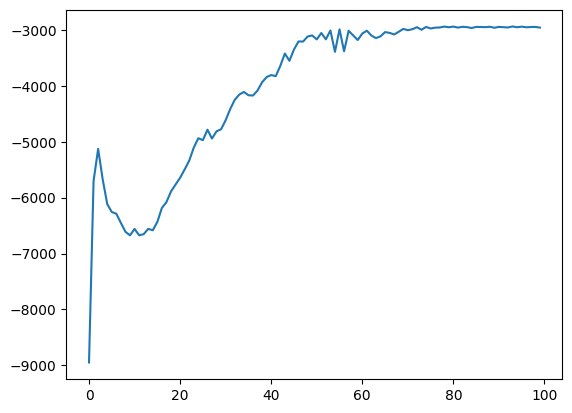

In [22]:
from gmm import GMM

gmm_K = 2

model = GMM(D, gmm_K, alpha_0=1000)

advi = ADVI(model, num_samples=5, batch_size=1000, lr=0.5, mode='meanfield', num_epochs=100)
advi.fit(x_train, method="Adam", plotting=True, use_grad_clip=False)

p: tensor([0.5253, 0.4747])
mean: tensor([[-0.9666,  2.9457],
        [-2.9043,  4.9765]])
sigma: tensor([[0.1231, 2.3785],
        [2.8305, 0.5445]])


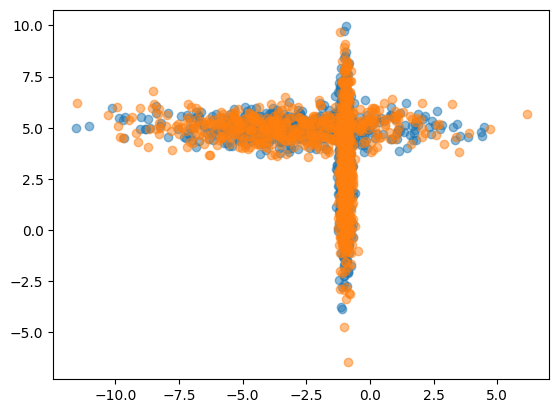

In [23]:
zeta_p = advi.model_params.vparams[0, :gmm_K].detach()
mean = advi.model_params.vparams[0, gmm_K:gmm_K + gmm_K*D].view(gmm_K, D).detach()
log_sigma = advi.model_params.vparams[0, gmm_K + gmm_K*D:gmm_K + 2*gmm_K*D].view(gmm_K, D).detach()
exp_sum = zeta_p.exp().sum() 
p = zeta_p.exp() / exp_sum
sigma = torch.exp(log_sigma)

print(f"p: {p}")
print(f"mean: {mean}")
print(f"sigma: {sigma}")

samples = model.rsample(1000, p, mean, sigma)

plt.scatter(x_train[:, 0], x_train[:, 1], alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.show()